In [2]:
#Black-Scholes formula implementation.
#Pricing, Greeks, and Payoff plots.
#This notebook implements the Black-Scholes formula for European Calls and Puts.
#It includes: 
# 1. A Black–Scholes pricing function (call/put),
# 2. A function for Greeks (Delta, Gamma, Vega, Theta, Rho),
# 3. Example usage with printed outputs,
# 4.Payoff diagram at expiry,
# 5.Option price vs spot plot (Black–Scholes prices),
# 6.Implied volatility solver and volatility smile plot.

#Key assumptions: continuous compunding, European options, dividend yield, volatility.


In [4]:
import numpy as np    #for math, arrays, logarithms,etc.;
from scipy.stats import norm   #normal distribution functions for d1/d2 in Black-Scholes 
import matplotlib.pyplot as plt   #plotting pay-off, price vs spot, volatility smile
%matplotlib inline  
#plot appears in the notebook directly

np.random.seed(0)  #for reproducibility if random numbers ae used later

In [8]:
#Black-Scholes Equation explained
#For a European option with possible dividend yield 'q':
# d1 = (ln(S/K)+(r-q+0.5*sigma^2)*T)/(sigma*sqrt(T))
# d2 = d1 - sigma*sqrt(T)

# Call price:  C = S * e^{-qT} * N(d1) - K * e^{-rT} * N(d2)  
# Put price:   P = K * e^{-rT} * N(-d2) - S * e^{-qT} * N(-d1)

# ! N() is the standard normal CDF

# Explanation of variables:
# T = time to maturity in years (e.g. 0.5 = 6 months)
# S = spot price of the underlying (current price)
# K = strike price 
# r = continuously compounded risk-free rate
# q = continuous dividend yield (0 if none)
# sgima = annual volatility

In [9]:
def bs_price(S, K, T, r, sigma, q=0.0, option_type='call'):
  
    S = float(S)
    K = float(K)

    # if option is already expired, price = intrinsic value
    if T <= 0:
        if option_type == 'call':
            return max(0.0, S - K)
        else:
            return max(0.0, K - S)

    # avoid division by zero when sigma is zero (degenerate case)
    if sigma <= 0:
        # In sigma -> 0 limit, option is worth discounted intrinsic if forward-in-the-money
        forward = S * np.exp(-q * T) - K * np.exp(-r * T)
        if option_type == 'call':
            return max(0.0, forward)  # approximate
        else:
            return max(0.0, -forward)

    sqrtT = np.sqrt(T)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT

    if option_type == 'call':
        price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

    return float(price)


In [10]:
# Greeks computed analytically

# compute the common Black–Scholes Greeks:
# Delta: sensitivity to spot (∂Price/∂S).
# Gamma: second derivative w.r.t. spot (∂²Price/∂S²).
# Vega: sensitivity to volatility (∂Price/∂σ) — per 1 volatility unit.
# Theta: time decay (∂Price/∂t). Here given **per year** (so divide by 365 for per-day).
# Rho: sensitivity to interest rate (∂Price/∂r).

#! formulas below follow standard Black–Scholes derivations and include continuous dividend yield `q`.

In [11]:
def bs_greeks(S, K, T, r, sigma, q=0.0, option_type='call'):
    
    # compute Black–Scholes Greeks: Delta, Gamma, Vega, Theta, Rho.

    # returns

    # greeks : dict
      #  { 'Delta': ..., 'Gamma': ..., 'Vega': ..., 'Theta': ..., 'Rho': ... }
    #Notes: 
    
    # Theta returned is 'per year' (not per day). Divide by 365 for per-day.
    # Vega is the derivative w.r.t sigma (per 1.0 = 100 percentage points).
    
    S = float(S)
    K = float(K)

    # At expiry the Greeks are discontinuous; give simple finite-like values
    if T <= 0:
        if option_type == 'call':
            delta = 1.0 if S > K else 0.0
        else:
            delta = -1.0 if S < K else 0.0
        return dict(Delta=delta, Gamma=0.0, Vega=0.0, Theta=0.0, Rho=0.0)

    sqrtT = np.sqrt(T)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    pdf_d1 = norm.pdf(d1)

    # Delta
    if option_type == 'call':
        delta = np.exp(-q * T) * norm.cdf(d1)
    else:
        # put delta: e^{-qT} (N(d1) - 1)
        delta = np.exp(-q * T) * (norm.cdf(d1) - 1.0)

    # Gamma (same for call and put)
    gamma = (np.exp(-q * T) * pdf_d1) / (S * sigma * sqrtT)

    # Vega (per 1 vol unit)
    vega = S * np.exp(-q * T) * pdf_d1 * sqrtT

    # Theta (annualized)
    # common first term: -S * sigma * e^{-qT} * pdf(d1) / (2*sqrtT)
    first = - (S * sigma * np.exp(-q * T) * pdf_d1) / (2.0 * sqrtT)
    if option_type == 'call':
        theta = (first
                 - r * K * np.exp(-r * T) * norm.cdf(d2)
                 + q * S * np.exp(-q * T) * norm.cdf(d1))
    else:
        theta = (first
                 + r * K * np.exp(-r * T) * norm.cdf(-d2)
                 - q * S * np.exp(-q * T) * norm.cdf(-d1))

    # Rho
    if option_type == 'call':
        rho = K * T * np.exp(-r * T) * norm.cdf(d2)
    else:
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2)

    return dict(Delta=float(delta),
                Gamma=float(gamma),
                Vega=float(vega),
                Theta=float(theta),
                Rho=float(rho))
    


In [12]:
# Example: compute prices and Greeks for sample parameters

#for simulation we price a 6-month ATM option with 20% volatility and a 1% continuous risk-free rate.


In [13]:
# Example parameters
S = 100.0      # current spot
K = 100.0      # strike (ATM)
T = 0.5        # time to maturity in years (6 months)
r = 0.01       # continuous risk-free rate (1%)
sigma = 0.20   # volatility (20% annual)
q = 0.0        # dividend yield (0%)

# Compute prices
call_price = bs_price(S, K, T, r, sigma, q=q, option_type='call')
put_price  = bs_price(S, K, T, r, sigma, q=q, option_type='put')

# Compute Greeks
call_greeks = bs_greeks(S, K, T, r, sigma, q=q, option_type='call')
put_greeks  = bs_greeks(S, K, T, r, sigma, q=q, option_type='put')

# Print formatted results
print(f"Parameters: S={S}, K={K}, T={T}y, r={r}, sigma={sigma}, q={q}")
print("-" * 50)
print(f"Call price: {call_price:.6f}")
for name, val in call_greeks.items():
    # Theta may be negative; format with sign
    print(f"  Call {name:6s}: {val: .6f}")
print("-" * 50)
print(f"Put  price: {put_price:.6f}")
for name, val in put_greeks.items():
    print(f"  Put  {name:6s}: {val: .6f}")


Parameters: S=100.0, K=100.0, T=0.5y, r=0.01, sigma=0.2, q=0.0
--------------------------------------------------
Call price: 5.876024
  Call Delta :  0.542235
  Call Gamma :  0.028051
  Call Vega  :  28.051246
  Call Theta : -6.093724
  Call Rho   :  24.173739
--------------------------------------------------
Put  price: 5.377272
  Put  Delta : -0.457765
  Put  Gamma :  0.028051
  Put  Vega  :  28.051246
  Put  Theta : -5.098712
  Put  Rho   : -25.576885


In [15]:
## Payoff at expiry (intrinsic payoff)

# the plot shows the piecewise linear payoff at expiry for a plain **call** and **put**.
# Note: Black–Scholes prices before expiry include time value; payoff is what you receive at expiry.


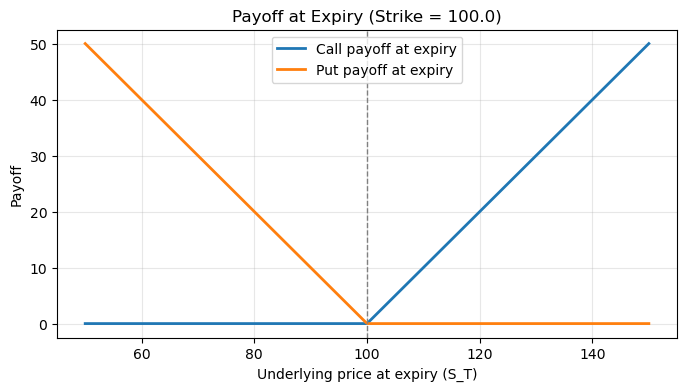

In [16]:
# Payoff plot parameters (use same K)
S_min = 0.5 * K
S_max = 1.5 * K
S_range = np.linspace(S_min, S_max, 300)

call_payoff = np.maximum(S_range - K, 0.0)
put_payoff  = np.maximum(K - S_range, 0.0)

plt.figure(figsize=(8, 4))
plt.plot(S_range, call_payoff, label='Call payoff at expiry', linewidth=2)
plt.plot(S_range, put_payoff, label='Put payoff at expiry', linewidth=2)
plt.axvline(K, linestyle='--', color='gray', linewidth=1)
plt.title(f'Payoff at Expiry (Strike = {K})')
plt.xlabel('Underlying price at expiry (S_T)')
plt.ylabel('Payoff')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [17]:
## Black–Scholes price vs Spot (for fixed T)

# shows how the Black–Scholes option price depends on the underlying spot price S (for the same T).
#this helps visualize time value vs intrinsic value.


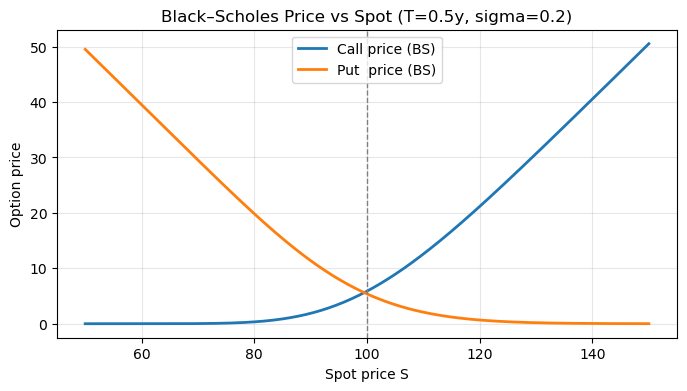

In [18]:
S_vals = np.linspace(0.5 * K, 1.5 * K, 300)
call_prices = [bs_price(Sv, K, T, r, sigma, q=q, option_type='call') for Sv in S_vals]
put_prices  = [bs_price(Sv, K, T, r, sigma, q=q, option_type='put') for Sv in S_vals]

plt.figure(figsize=(8, 4))
plt.plot(S_vals, call_prices, label='Call price (BS)', linewidth=2)
plt.plot(S_vals, put_prices, label='Put  price (BS)', linewidth=2)
plt.axvline(K, linestyle='--', color='gray', linewidth=1)
plt.title(f'Black–Scholes Price vs Spot (T={T}y, sigma={sigma})')
plt.xlabel('Spot price S')
plt.ylabel('Option price')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [19]:
# Implied Volatility using Brent's Method

#Given a **market price** of an option, we can solve for the implied volatility `sigma` that makes the Black–Scholes price equal to the market price.

# 1. uses `scipy.optimize.brentq` to find the root of `BS_price(sigma) - market_price = 0`.
# 2. works for both **call** and **put** options.
# 3. requires a reasonable **volatility bracket** (e.g., 0.0001 to 5.0).


In [20]:
from scipy.optimize import brentq

def implied_vol(market_price, S, K, T, r, q=0.0, option_type='call', sigma_bounds=(1e-4, 5.0)):
  
    # define function whose root we want: f(sigma) = BS_price(sigma) - market_price
    def objective(sigma):
        return bs_price(S, K, T, r, sigma, q=q, option_type=option_type) - market_price

    try:
        sigma_imp = brentq(objective, sigma_bounds[0], sigma_bounds[1], maxiter=500, xtol=1e-8)
        return sigma_imp
    except ValueError:
        # Root not found in the interval
        return np.nan

# example usage:
# suppose a call option trades at 5.0
market_call_price = 5.0
sigma_call_imp = implied_vol(market_call_price, S, K, T, r, q=q, option_type='call')
print(f"Implied volatility for call (market price={market_call_price}): {sigma_call_imp:.4f}")

# suppose a put option trades at 4.8
market_put_price = 4.8
sigma_put_imp = implied_vol(market_put_price, S, K, T, r, q=q, option_type='put')
print(f"Implied volatility for put  (market price={market_put_price}): {sigma_put_imp:.4f}")


Implied volatility for call (market price=5.0): 0.1688
Implied volatility for put  (market price=4.8): 0.1794


In [21]:
## implied Volatility vs Strike (Volatility Smile)

# the plot computes the implied volatility for a **range of strikes** given the same market option price and maturity.  
# it helps visualize the **volatility smile/skew**, which is observed in real markets.


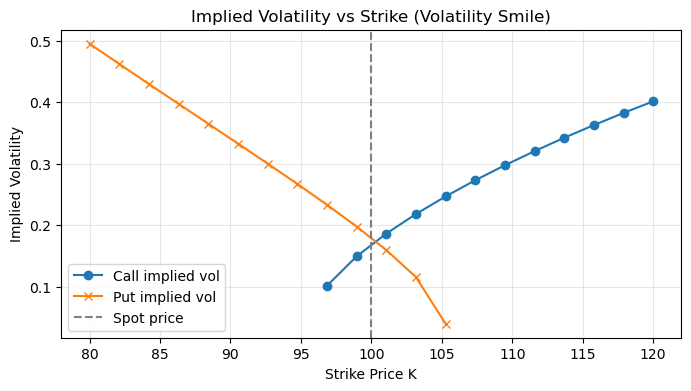

In [22]:
# example market prices for a fixed T
# for demonstration, assume the market price is constant (could be real quotes)
market_price_call = 5.0  # constant market price for call
market_price_put  = 4.8  # constant market price for put

# Strike range around spot
K_vals = np.linspace(0.8 * S, 1.2 * S, 20)

# Compute implied vol for each strike
imp_vol_call = [implied_vol(market_price_call, S, Kx, T, r, q=q, option_type='call') for Kx in K_vals]
imp_vol_put  = [implied_vol(market_price_put, S, Kx, T, r, q=q, option_type='put') for Kx in K_vals]

# Plot the smile
plt.figure(figsize=(8, 4))
plt.plot(K_vals, imp_vol_call, marker='o', label='Call implied vol')
plt.plot(K_vals, imp_vol_put, marker='x', label='Put implied vol')
plt.axvline(S, linestyle='--', color='gray', label='Spot price')
plt.title('Implied Volatility vs Strike (Volatility Smile)')
plt.xlabel('Strike Price K')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
